# Apply GAE to BlogCatalog

In [1]:
cd /home/sl/Code/Research/nw2vec

/home/sl/Code/Research/nw2vec


In [2]:
import csv
from collections import defaultdict
import os
import pickle

import numpy as np
import networkx as nx
import scipy.sparse as sp

import keras
from keras_tqdm import TQDMNotebookCallback as TQDMCallback
import tqdm

from nw2vec import utils
import settings

Using TensorFlow backend.


In [3]:
# ### PARAMETERS ###

# Data
crop = 200 # None

In [4]:
# ### MISC. SETUP VARIABLES ###

# if 'CUDA_VISIBLE_DEVICES' not in os.environ:
#     raise ValueError('CUDA_VISIBLE_DEVICES not set')
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# MODEL_NAME = os.path.split(__file__)[-1][:-3]
# MODEL_PATH = os.path.join(settings.SCALE_PATH, MODEL_NAME)
# if not os.path.exists(MODEL_PATH):
#     os.mkdir(MODEL_PATH)

In [5]:
# ### LOAD DATA ###

# ## Get the full list of nodes and groups ##

# nodes
nodes = []
with open('datasets/BlogCatalog-dataset/data/nodes.csv') as csvfile:
    reader = csv.reader(csvfile)
    nodes = [int(row[0]) for row in reader]
if crop is not None:
    nodes = nodes[:crop]
assert len(nodes) == len(set(nodes))
nodes = set(nodes)

# groups
groups = []
with open('datasets/BlogCatalog-dataset/data/groups.csv') as csvfile:
    reader = csv.reader(csvfile)
    groups = [int(row[0]) for row in reader]
assert len(groups) == len(set(groups))
groups = set(groups)


# ## Generate graph from edges and node data ##

# Read edges.csv and make a network out of it
edges = defaultdict(list)
with open('datasets/BlogCatalog-dataset/data/edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes and int(row[1]) in nodes:
                edges[int(row[0])].append(int(row[1]))
        else:
            edges[int(row[0])].append(int(row[1]))

g = nx.from_dict_of_lists(edges, create_using=nx.Graph())
if crop is not None:
    g.add_nodes_from(nodes)

# Read group-edges.csv and add that info to each node
group_edges = defaultdict(list)
with open('datasets/BlogCatalog-dataset/data/group-edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes:
                group_edges[int(row[0])].append(int(row[1]))
        else:
            group_edges[int(row[0])].append(int(row[1]))

for node, data in g.nodes.items():
    data['groups'] = group_edges[node]


# ## Sanity checks ##

assert set(g.nodes) == nodes
if crop is None:
    assert set().union(*[groups for _, groups in g.nodes(data='groups')]) == \
        groups

In [6]:
# ### DEFINE TRAINING LABELS ###

labels = np.zeros((len(nodes), len(groups)))
nodes_offset = min(nodes)
groups_offset = min(groups)
for n, data in g.nodes.items():
    labels[n - nodes_offset, np.array(data['groups']) - groups_offset] = 1

features_orig = sp.coo_matrix(utils.scale_center(labels))

In [7]:
# ### BUILD THE ADJ ###

n_nodes = len(nodes)
nx_node_ordering = np.array(sorted([[n - 1, i] for i, n in enumerate(g.nodes)]))[:, 1]
adj = nx.adjacency_matrix(g).astype(np.float32)[nx_node_ordering, :][:, nx_node_ordering]

### Begin GAE code

In [8]:
import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 20000, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_vae', 'Model string.')

# Workaround for Jupyter having an '-f' flag in its sys.argv -- this is ignored
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [10]:
model_str = FLAGS.model

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

#adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
#adj = adj_train

# Some preprocessing
adj_norm = preprocess_graph(adj)

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features_orig)
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

adj_label = adj + sp.eye(adj.shape[0])
adj_label = sparse_to_tuple(adj_label)

### Comparing with nw2vec

#### KL

In [11]:
kl = (0.5 / num_nodes) * tf.reduce_mean(
    tf.reduce_sum(
        1 - model.z_log_std - tf.square(model.z_mean) - tf.exp(- model.z_log_std), 1
    )
)

feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})

sess.run(kl, feed_dict=feed_dict)

-0.00056259154

#### Adj loss

In [12]:
import scipy.special
from contextlib import contextmanager

In [13]:
@contextmanager
def seeded_session():
    tf.set_random_seed(1)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    yield sess, feed_dict

In [14]:
# Compute embeddings
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})
adj_pred_logit = sess.run(model.reconstructions, feed_dict=feed_dict)
adj_loss = sess.run(norm
                    * tf.reduce_mean(
                        tf.nn.weighted_cross_entropy_with_logits(
                            logits=adj_pred_logit,
                            targets=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                         validate_indices=False),
                                               [-1]),
                            pos_weight=pos_weight)
                    ),
                    feed_dict=feed_dict)

adj_loss

1.7194288

In [15]:
# adj_pred_logit

In [16]:
# import matplotlib.pyplot as plt

In [17]:
# q_pred = np.concatenate([sess.run(model.z_mean, feed_dict=feed_dict),
#                          sess.run(model.z_log_d, feed_dict=feed_dict)], axis=1)

# fig, ax = plt.subplots(1, 1, figsize=(8, (crop / 100) * 8))
# im = ax.imshow(q_pred)
# plt.colorbar(im, ax=ax)

In [18]:
# np.save('q_pred_gae.npy', q_pred)

### Interlude: predictions before training

In [19]:
import matplotlib.pyplot as plt
import scipy.special

In [20]:
# Compute embeddings
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})
embs = [sess.run(model.z, feed_dict=feed_dict) for _ in range (10)]

# Compute predicted adj
adj_pred = np.mean([scipy.special.expit(emb.dot(emb.T)) for emb in embs], axis=0)

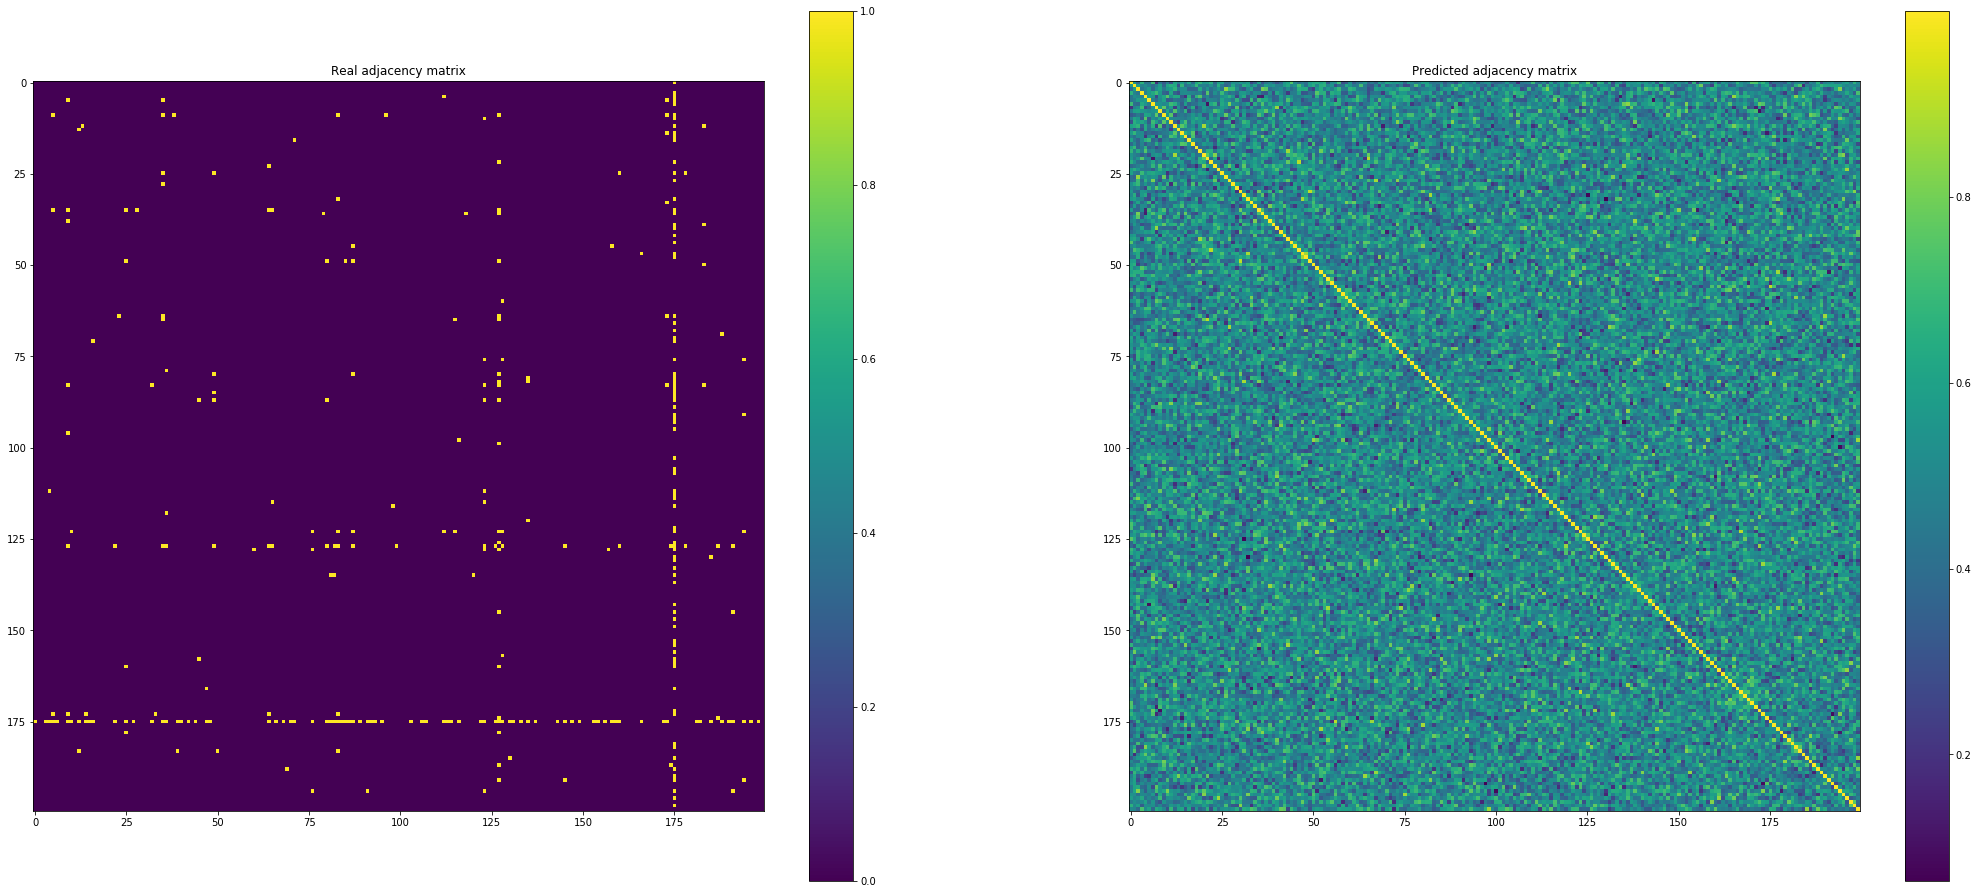

In [21]:
n_features_plot = crop

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((crop / 100) * 18, (crop / 100) * 8))

im1 = ax1.imshow(adj.toarray()[:n_features_plot, :][:, :n_features_plot])
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred[:n_features_plot, :][:, :n_features_plot])
#im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

### Resume training

In [22]:
train_losses = []
train_accuracies = []

# Train model
for epoch in tqdm.tqdm_notebook(range(FLAGS.epochs)):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    train_losses.append(outs[1])
    train_accuracies.append(outs[2])

## Results

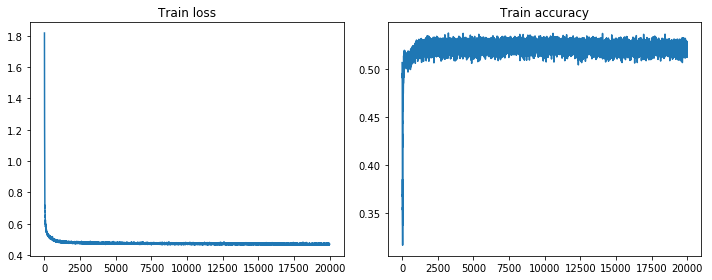

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(2 * 5, 4))
ax1.plot(train_losses)
ax1.set_title('Train loss')
ax2.plot(train_accuracies)
ax2.set_title('Train accuracy')
fig.tight_layout()

In [24]:
np.min(train_losses)

0.46299312

In [25]:
# Compute embeddings
feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
feed_dict.update({placeholders['dropout']: 0})
embs = [sess.run(model.z, feed_dict=feed_dict) for _ in range (10)]

# Compute predictions
q_pred = np.concatenate([sess.run(model.z_mean, feed_dict=feed_dict),
                         sess.run(model.z_log_std, feed_dict=feed_dict)], axis=1)
adj_pred = np.mean([scipy.special.expit(emb.dot(emb.T)) for emb in embs], axis=0)

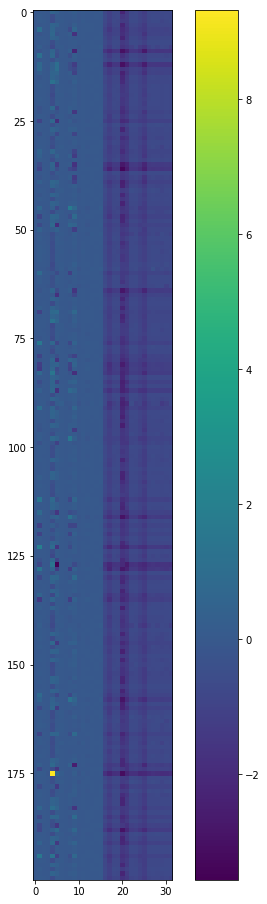

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, (crop / 100) * 8))
im = ax.imshow(q_pred)
plt.colorbar(im, ax=ax)

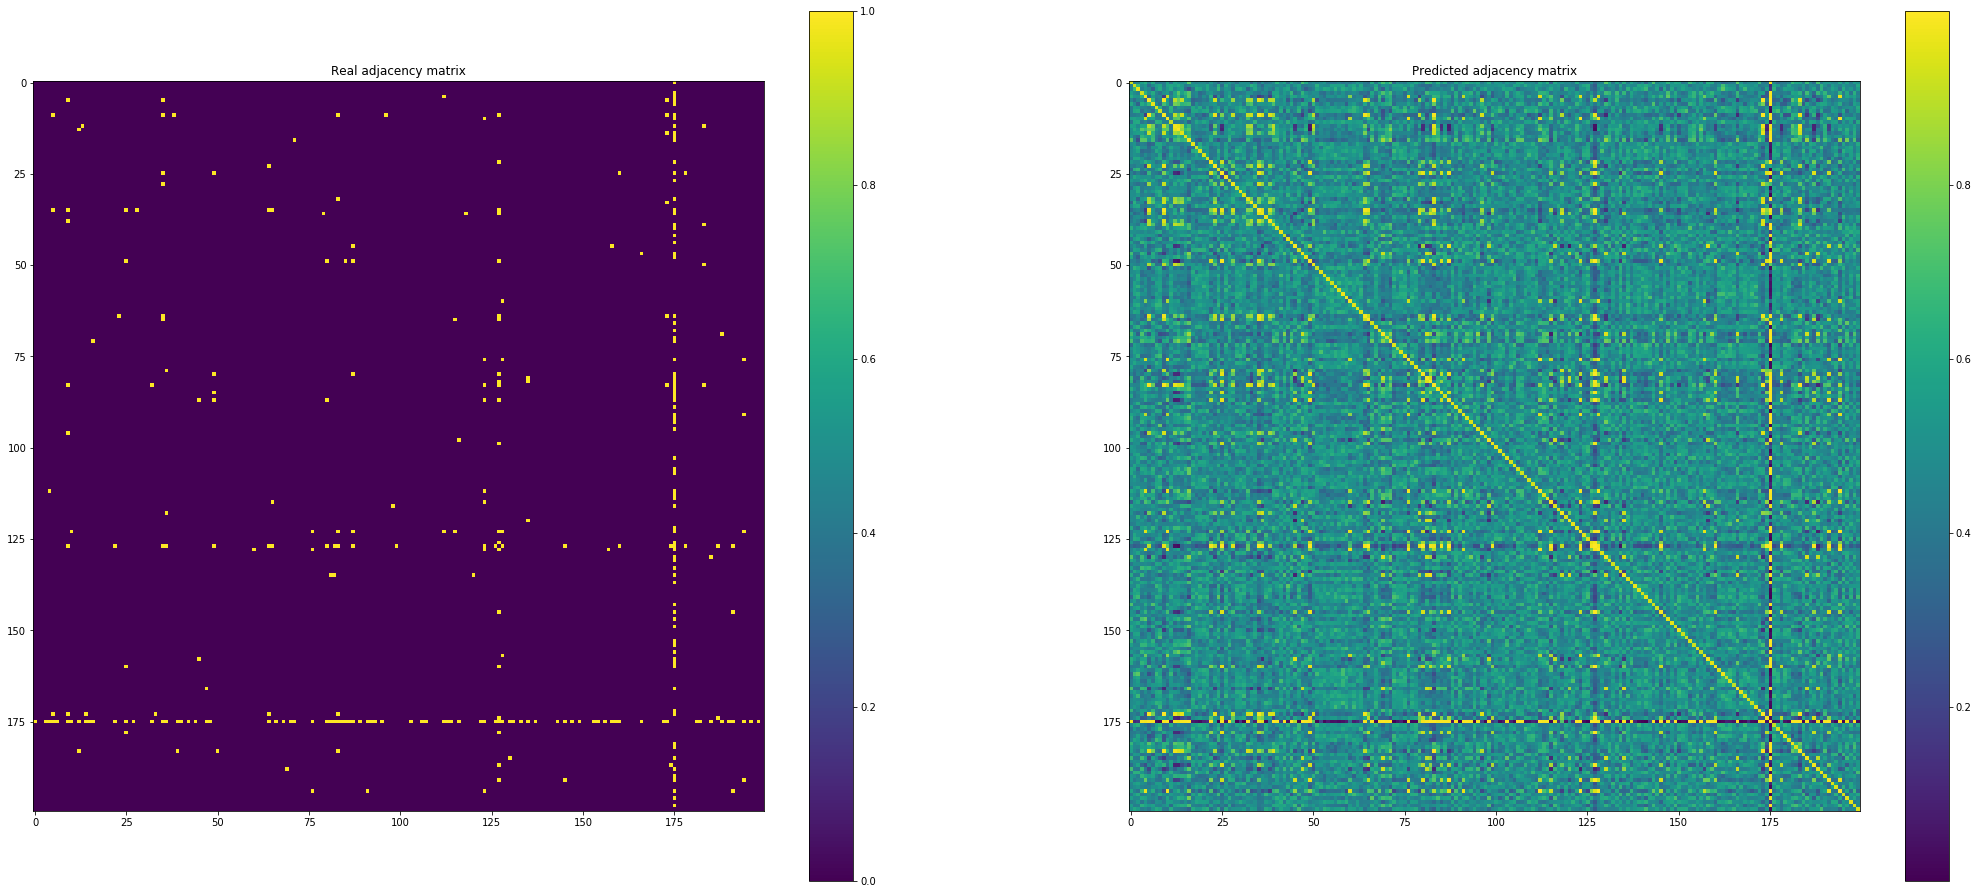

In [27]:
n_features_plot = crop

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=((crop / 100) * 18, (crop / 100) * 8))

im1 = ax1.imshow(adj.toarray()[:n_features_plot, :][:, :n_features_plot])
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred[:n_features_plot, :][:, :n_features_plot])
#im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

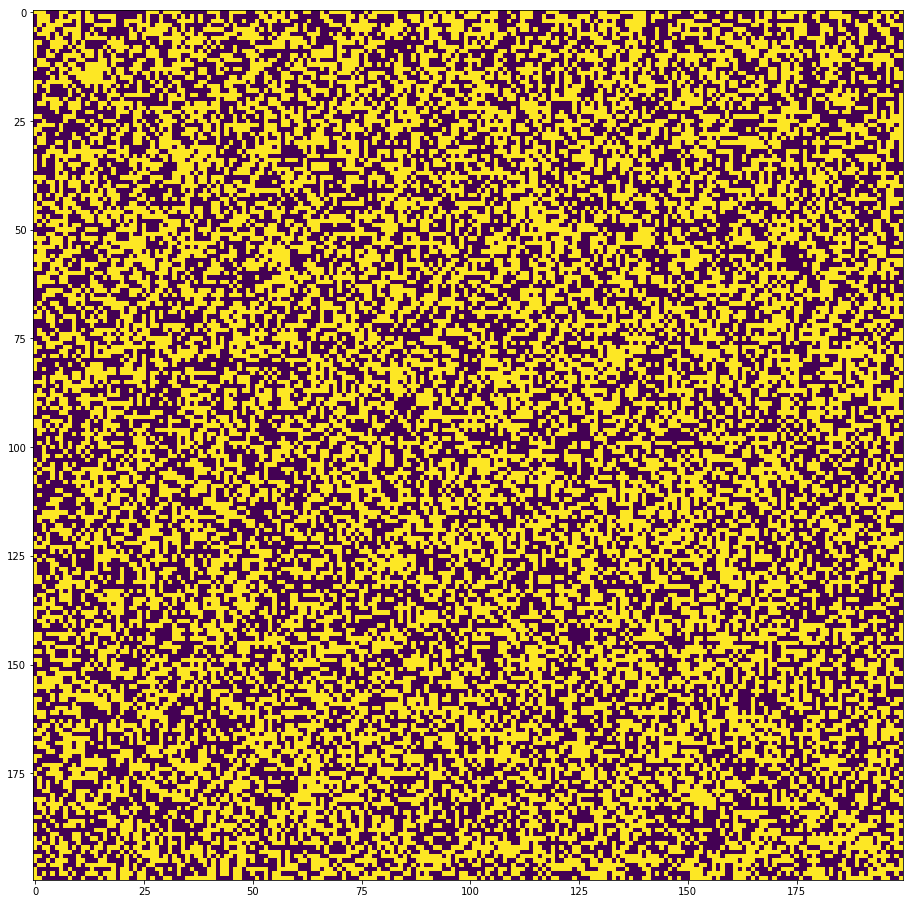

In [28]:
fig, ax = plt.subplots(1, 1, figsize=((crop / 100) * 8, (crop / 100) * 8))
ax.imshow(np.random.binomial(1, adj_pred[:n_features_plot, :][:, :n_features_plot]))

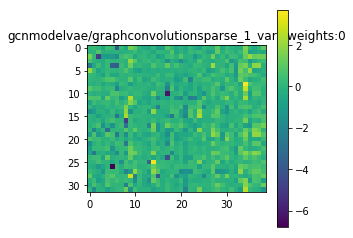

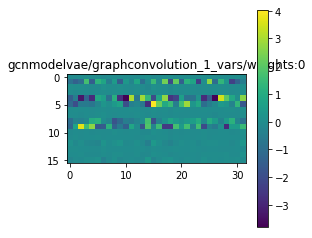

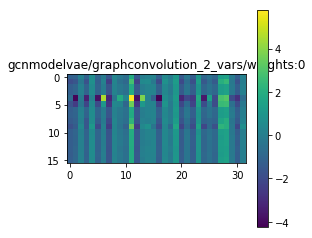

In [29]:
for var_name, var_value in model.vars.items():
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    im = ax.imshow(sess.run(var_value).T)
    ax.set_title(var_name)
    plt.colorbar(im, ax=ax)